In [1]:
# %pip install opencv-python
%pip install imageio[ffmpeg]
%pip install tqdm

In [2]:
# Mount Google Drive
from google.colab import drive
import os

drive.mount('/content/gdrive')
# Define base folder path
base_path = '/content/gdrive/MyDrive/RGB_data_stream'

Mounted at /content/gdrive


In [3]:
import os

csv_path = os.path.join(base_path,'data/3DYoga90_corrected.csv')
sequence_path = os.path.join(base_path, 'short/downloaded_log.txt')
save_path = os.path.join(base_path, 'Second_Resnet_nov6')
os.makedirs(save_path, exist_ok=True)
pose_list = ['mountain', 'half-way-lift', 'standing-forward-bend', 'downward-dog']
NUM_CLASSES = len(pose_list)
video_dir = os.path.join(base_path, 'short')
preprocessed_dir = os.path.join(base_path, 'complete_pre_processed')
os.makedirs(preprocessed_dir, exist_ok=True)
horz_aug =  os.path.join(base_path, 'horz_aug')
os.makedirs(horz_aug, exist_ok=True)

In [4]:
# Constants
FRAME_HEIGHT = 224  # VGG16 input size
FRAME_WIDTH = 224
SEQUENCE_LENGTH = 5

In [5]:
import os
import torch
import pandas as pd
import numpy as np
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import imageio

class YogaVideoDataset(Dataset):
    def __init__(self, csv_path, sequence_path, pose_list, video_dir, preprocessed_dir, aug_preprocessed_dir):
        with open(sequence_path) as f:
            sequence_list = f.read().splitlines()
            sequence_list = [int(x) for x in sequence_list]

        self.df = pd.read_csv(csv_path)
        self.df = self.df[self.df['sequence_id'].isin(sequence_list)]
        self.df = self.df[self.df['l3_pose'].isin(pose_list)]

        self.pose_to_idx = {pose: idx for idx, pose in enumerate(pose_list)}
        self.length_of_dataset = len(self.df)

        self.video_dir = video_dir
        self.preprocessed_dir = preprocessed_dir
        self.aug_preprocessed_dir = aug_preprocessed_dir

        os.makedirs(self.preprocessed_dir, exist_ok=True)
        os.makedirs(self.aug_preprocessed_dir, exist_ok=True)

        self.transforms = transforms.Compose([
            transforms.Resize((FRAME_HEIGHT, FRAME_WIDTH)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        self.flip_transform = transforms.RandomHorizontalFlip(p=1.0)  # Always flip horizontally

    def __len__(self):
        return self.length_of_dataset

    def __getitem__(self, i):
        sequence_id = self.df.iloc[i]['sequence_id']
        pose = self.df.iloc[i]['l3_pose']
        label = self.pose_to_idx[pose]

        # Path to preprocessed tensor files
        preprocessed_path = os.path.join(self.preprocessed_dir, f"{sequence_id}.pt")
        aug_preprocessed_path = os.path.join(self.aug_preprocessed_dir, f"{sequence_id}.pt")

        # Load original sequence if it exists
        if os.path.exists(preprocessed_path):
            frames = torch.load(preprocessed_path, weights_only=True)
        else:
            video_path = os.path.join(self.video_dir, f"{sequence_id}.mp4")
            frames = self._get_frames(video_path)
            torch.save(frames, preprocessed_path)

        # Apply horizontal flip augmentation if not already saved
        if not os.path.exists(aug_preprocessed_path):
            augmented_frames = self.flip_transform(frames)  # Apply horizontal flip
            print(aug_preprocessed_path)
            torch.save(augmented_frames, aug_preprocessed_path)

        return frames, label

    def _get_frames(self, video_path):
        reader = imageio.get_reader(video_path, 'ffmpeg')
        fps = imageio.get_reader(video_path, 'ffmpeg').get_meta_data()['fps'] // 1
        total_frames = reader.count_frames()

        indices = np.arange(0, fps - 1, fps // SEQUENCE_LENGTH, dtype=int)

        frames = []
        for i, frame in enumerate(reader):
            if i % fps in indices:
                frame = Image.fromarray(frame)
                frame = self.transforms(frame)
                frames.append(frame)

        reader.close()
        frames = torch.stack(frames)
        return frames

In [6]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    frames, labels = zip(*batch)

    # Pad the frames to the maximum sequence length in the batch
    frames_padded = pad_sequence(frames, batch_first=True, padding_value=0)  # Shape: [batch_size, max_seq_len, 3, 224, 224]

    labels = torch.tensor(labels)

    return frames_padded, labels

In [7]:
from tqdm import tqdm
from torch.utils.data import DataLoader

dataset = YogaVideoDataset(csv_path, sequence_path, pose_list, video_dir, preprocessed_dir, horz_aug)
# loader = DataLoader(
#     dataset,
#     batch_size=32,
#     shuffle=True,
#     num_workers=2,
#     pin_memory=True,
#     collate_fn=collate_fn  # Use custom collate function
# )
# train_loader_tqdm = tqdm(enumerate(loader), total=len(loader), desc="Processing Clips")
# for batch_idx, (inputs, labels) in train_loader_tqdm:
#           print("DONE")
for i, data in enumerate(dataset):
  print('Data', i)

/content/gdrive/MyDrive/RGB_data_stream/horz_aug/1000.pt
Data 0
/content/gdrive/MyDrive/RGB_data_stream/horz_aug/1002.pt
Data 1
/content/gdrive/MyDrive/RGB_data_stream/horz_aug/1003.pt
Data 2
/content/gdrive/MyDrive/RGB_data_stream/horz_aug/1004.pt
Data 3
/content/gdrive/MyDrive/RGB_data_stream/horz_aug/1005.pt
Data 4
/content/gdrive/MyDrive/RGB_data_stream/horz_aug/1006.pt
Data 5
/content/gdrive/MyDrive/RGB_data_stream/horz_aug/1007.pt
Data 6
/content/gdrive/MyDrive/RGB_data_stream/horz_aug/1008.pt
Data 7
/content/gdrive/MyDrive/RGB_data_stream/horz_aug/1009.pt
Data 8
/content/gdrive/MyDrive/RGB_data_stream/horz_aug/1010.pt
Data 9
/content/gdrive/MyDrive/RGB_data_stream/horz_aug/1011.pt
Data 10
/content/gdrive/MyDrive/RGB_data_stream/horz_aug/1012.pt
Data 11
/content/gdrive/MyDrive/RGB_data_stream/horz_aug/1013.pt
Data 12
/content/gdrive/MyDrive/RGB_data_stream/horz_aug/1014.pt
Data 13
/content/gdrive/MyDrive/RGB_data_stream/horz_aug/1015.pt
Data 14
/content/gdrive/MyDrive/RGB_data_st

In [9]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
denormalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(imagenet_mean, imagenet_std)],
    std=[1/s for s in imagenet_std]
)

<ipython-input-10-a8daa28153e2>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_frames = torch.load(original_path)
<ipython-input-10-a8daa28153e2>:17: FutureWarni

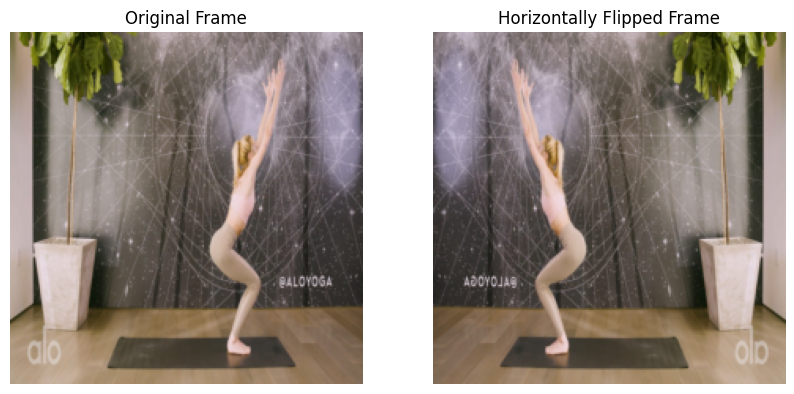

In [10]:
import torch
import matplotlib.pyplot as plt
import os
from torchvision.transforms import ToPILImage

def plot_sample(preprocessed_dir, aug_dir, sample_number):
    # Define file paths for the original and augmented sequences
    original_path = os.path.join(preprocessed_dir, f"{sample_number}.pt")
    augmented_path = os.path.join(aug_dir, f"{sample_number}.pt")

    # Load the tensors
    if not os.path.exists(original_path) or not os.path.exists(augmented_path):
        print(f"Sample {sample_number} not found in either {preprocessed_dir} or {aug_dir}")
        return

    original_frames = torch.load(original_path)
    augmented_frames = torch.load(augmented_path)

    # Select the first frame (or any frame you prefer to visualize)
    frame_idx = 0
    original_frame = original_frames[frame_idx]
    augmented_frame = augmented_frames[frame_idx]

    original_frame = denormalize(original_frame)
    augmented_frame = denormalize(augmented_frame)

    # Convert tensors to PIL images for visualization
    to_pil = ToPILImage()
    original_image = to_pil(original_frame)
    augmented_image = to_pil(augmented_frame)

    # Plot both images side-by-side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(original_image)
    ax[0].set_title("Original Frame")
    ax[0].axis("off")

    ax[1].imshow(augmented_image)
    ax[1].set_title("Horizontally Flipped Frame")
    ax[1].axis("off")

    tsave = os.path.join(aug_dir, 'aug_result.png')
    plt.savefig(tsave)
    plt.show()

# Example usage:
plot_sample(preprocessed_dir, horz_aug, 1000)
